# Árvores de regressão

Nesta bateria de exercícios, vamos botar em prática o que aprendemos com a base de dados imobiliários de Boston, que pode ser baixada do módulo ```datasets``` do scikitlearn. Essa base de dados possui uma linha por cidade, o objetivo é prever, ou fornecer uma estimativa de ```MEDV```, ou o valor mediano de casas ocupadas pelo dono, dadas as demais variáveis usadas como explicativas.

A descrição das variáveis está abaixo:

| Variavel | Descrição|
|-|-|
|CRIM| taxa de crimes per-cápita da cidade | 
|ZN| proporção de terrenos residenciais zoneados para lotes com mais de 25.000 pés quadrados. |
|INDUS| proporção de acres de negócios não varejistas por cidade |
|CHAS |vale 1 se o terreno faz fronteira com o *Charles River*; 0 caso contrário |
|NOX| Concentração de óxido nítrico (em partes por 10 milhões) |
|RM| número médio de quartos por habitação |
|AGE| proporção de unidades ocupadas pelo proprietário construídas antes de 1940 |
|DIS| distâncias ponderadas até cinco centros de empregos de Boston |
|RAD| índice de acessibilidade a rodovias radiais |
|TAX| taxa de imposto sobre a propriedade de valor total por \\$10,000 |
|PTRATIO| razão pupilo-professor da cidade |
|B| $ 1000 (Bk - 0,63) ^ 2 $ onde Bk é a proporção de negros por cidade |
|LSTAT| \%status inferior da população |
|MEDV| (variável resposta) Valor mediano das casas ocupadas pelo proprietário em US $ 1.000|

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [4]:
arquivo = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'

boston = pd.read_csv(arquivo)
#remove também a coluna 'b' e 'lstat' do dataset
boston = boston.drop(columns=['b','lstat'], axis=1)


X = boston.drop(columns=['medv'], axis=1).copy()
y = boston[['medv']]

In [5]:
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7


In [6]:
y.head()

,medv
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


### Funções

In [7]:
# Checa dados preliminares da base de dados

def checking_base(df) -> None:
    
    print(f'Shape pré-tratamento: {df.shape} \n')
    print(f'Os tipos de dados são: \n{df.dtypes} \n\n')
    
    print('Checagem de duplicatas:')
    duplicated_values(df)
     
    print('Checagem de valores missing:')
    missing_values(df)
    
    return None

In [8]:
# Checa se há dados faltantes

def missing_values(df) -> None:
    
    if True in df.isna().any().to_list():
        print('Verificar missing values. \n')
        print(df.isna().any())
        print(df.isna().count)
    else:
        print('Não há missing values.')
    
    return None

In [9]:
# checa se há duplicatas

def duplicated_values(df) -> None:
    
    if df.shape[0] == df.drop_duplicates().shape[0]:
        print('Não há duplicatas. \n')
    else:
        print(f'Porcentagem de dados duplicados: {round(df.shape[0]/boston.df[0]*100,2)}% \n')
    
    return None

In [10]:
# Calcula o MSE para as árvores deste problema

def calculo_mse(clt, X_train, X_test, y_test,y_train) -> None:

    y_pred_train = clt.predict(X_train)
    y_pred_test = clt.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    print(f'MSE train: {round(mse_train,2)}')
    print(f'MSE teste: {round(mse_test,2)}')
    
    return None

### 1. Certifique-se de que esta base está no formato adequado para o scikitlearn.
ok, essa tarefa é tão fácil que você vai até desconfiar. Mas é preciso ter confiança sobre os dados que se usa ;)

In [11]:
checking_base(boston)

Shape pré-tratamento: (506, 12) 

Os tipos de dados são: 
crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
medv       float64
dtype: object 


Checagem de duplicatas:
Não há duplicatas. 

Checagem de valores missing:
Não há missing values.


#### A base de dados está pronta para uso.

### 2.  Visualize a matriz de correlação, e veja se aparentemente você encontra alguma variável com potencial preditivo interessante.

In [12]:
# orbservando apenas a relação da variável target com as outras:

boston[boston.columns[1:]].corr()['medv'].sort_values(ascending=False).to_frame()

,medv
medv,1.000000
rm,0.695360
zn,0.360445
dis,0.249929
chas,0.175260
age,-0.376955
rad,-0.381626
nox,-0.427321
tax,-0.468536
indus,-0.483725


<AxesSubplot:>

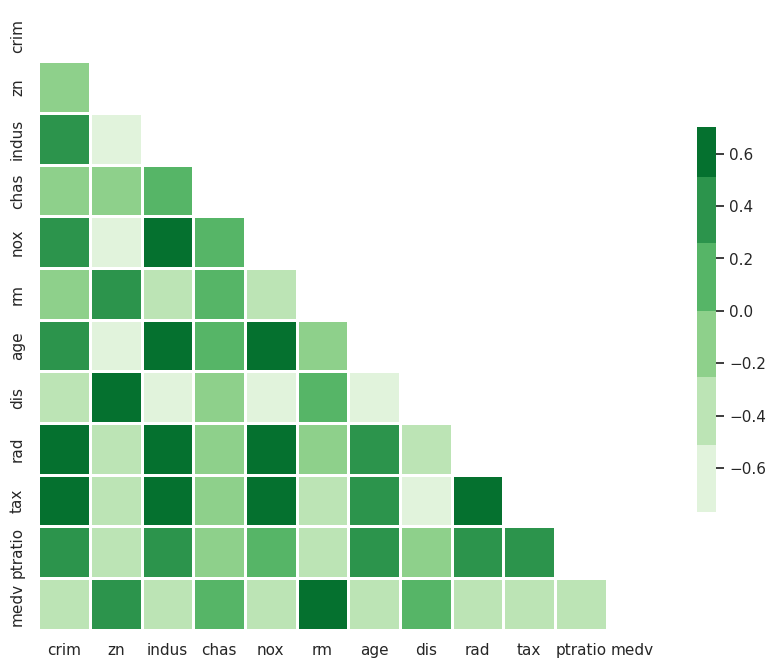

In [13]:
# construindo um heatmap para melhor analisar a matriz de correlação:

sns.set_theme(style="white")
corr = boston.corr()
mask = np.triu(boston.corr())
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette("Greens")

sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap,
            vmax=.7, 
            center=0,
            square=True, 
            linewidths=1, 
            cbar_kws={"shrink": .5}
           )


### É possível observar que a correlação entre medv e, por exemplo:

    Proporcional: 
        rm - Média de Quartos por habitação
        zn - proporção de terrenos residenciais zoneados para lotes com mais de 25.000 pés quadrados (aprox. 2300m2)
        dis - distâncias ponderadas até cinco centros de empregos de Boston
        chas - vale 1 se o terreno faz fronteira com o Charles River; 0 caso contrário
        
    Inversamente proporcional:
        ptratio - razão pupilo-professor da cidade
        indus - proporção de acres de negócios não varejistas por cidade
        tax - taxa de imposto sobre a propriedade de valor total por 10,000

### 3. Separe os dados em validação e teste

In [14]:
# separa a base de dados em 70% treino e 30% treino

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 4. Treine duas árvores, uma com profundidade máxima = 8, outra com profundidade máxima = 2.

In [15]:
# treinando as árvores
clt_2 = tree.DecisionTreeRegressor(max_depth=2, random_state=0)
clt_8 = tree.DecisionTreeRegressor(max_depth=8, random_state=0)
clts = [clt_2, clt_8]

for clt in clts:
    clt = clt.fit(X_train,y_train)

### 5. Calcule o MSE de cada uma das árvores do item anterior para a base de treinamento e para a base de testes.

In [16]:
calculo_mse(clt_2, X_train, X_test, y_test,y_train)

MSE train: 27.61
MSE teste: 40.17


In [17]:
calculo_mse(clt_8, X_train, X_test, y_test,y_train)

MSE train: 2.46
MSE teste: 49.58


### 6. Com base nos resultados do item anterior, qual árvore te parece mais adequada?

A árvore com profundidade 2, pois esta performa melhor na base de testes. A árvore com profundidade 8 pare estar 'overfitada'.

### 7. Faça uma visualização gráfica dessa árvore. Vamos discutir importância de variável mais adiante, mas veja a sua árvore, e pense um pouco: qual variável te parece mais "importante" na árvore?

In [32]:
dot_data = export_graphviz(clt_8, out_file=None, 
                           feature_names=X.columns, 
                           filled=True, 
                           rounded=True, 
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('regression_tree_clt_8', view=True)

A variável mais importante é a rm, que é a média de quartos por habitação. 

### 8. Execute os passos do exercício anterior, até que você tenha uma árvore de regressão predizendo o valor do imóvel na base de treinamento.

In [19]:
# utilizando o gridsearch para encontrar os melhores parâmetros

# Define os hiperparâmetros a serem testados
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Cria o objeto DecisionTreeRegressor
clf = DecisionTreeRegressor(random_state=0)

# Cria o objeto GridSearchCV
grid_search = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1)
# Executa o grid search
grid_search.fit(X_train, y_train)

# Imprime o melhor conjunto de parâmetros encontrado
print(grid_search.best_params_)

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.wa

{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 2}


/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


In [20]:
# Usando os parâmetros dados acima:
clf_10 = tree.DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=8, min_samples_split=2, random_state=0)

### 9.  Calcule o caminho indicado pelos CCP-alfas dessa árvore.


In [21]:
# Calcula o caminho do CCP para diferentes alphas
path = clf_10.cost_complexity_pruning_path(X_train, y_train)

# Obtém os valores de alpha e as impurezas
ccp_alphas, impurities = path.ccp_alphas, path.impurities

/home/jesse/.local/lib/python3.10/site-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


### 10. Para cada valor de alpha obtido no item 2, treine uma árvore com o respectivo alfa, e guarde essa árvore em uma lista.

In [22]:
# Cria uma lista de árvores para cada valor de alpha
arvores = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    arvores.append(clf)

### 11. Para cada árvore na lista, calcule o MSE da árvore.

In [23]:
# Calcula o MSE no conjunto de testes para cada árvore

mses = [mean_squared_error(y_test, clf.predict(X_test)) for clf in arvores]

### 12. Monte um gráfico do MSE pelo alpha, escolha um valor de alpha perto do ponto de mínimo do MSE

Text(0, 0.5, 'MSE')

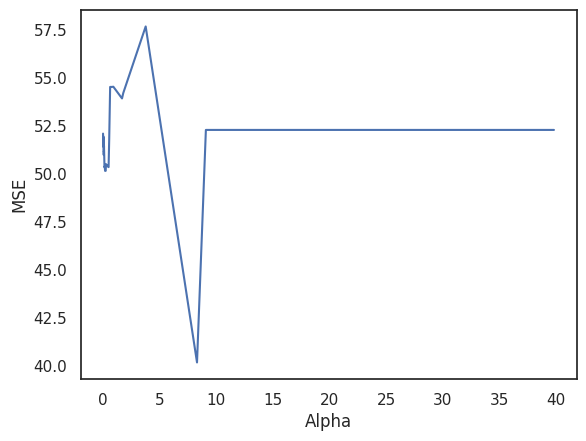

In [24]:
plt.plot(ccp_alphas, mses)
plt.xlabel('Alpha')
plt.ylabel('MSE')

Text(0, 0.5, 'Impureza')

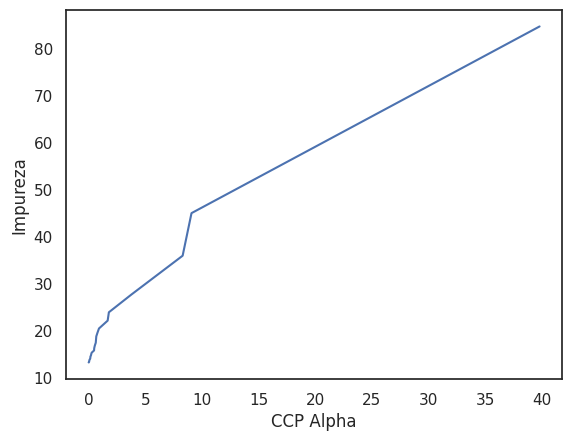

In [25]:
# utilizando também a impureza das folhas

plt.plot(ccp_alphas, impurities)
plt.xlabel('CCP Alpha')
plt.ylabel('Impureza')

In [26]:
# sem precisar confiar no olho...
melhor_clf = arvores[np.argmin(mses)]
melhor_arvore = melhor_clf.fit(X, y)

### 13. Calcule o R-quadrado dessa árvore encontrada no item acima

In [27]:
# calculando o r quadrado para a base de testes

y_pred = melhor_arvore.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R-Square = {r2}')

R-Square = 0.5854098918251318


### 14. Visualize esse árvore

In [37]:
dot_data = export_graphviz(melhor_arvore, out_file=None, 
                           feature_names=X.columns, 
                           filled=True, 
                           rounded=True, 
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('melhor_arvore', view=True)

'melhor_arvore.pdf'